# Источники данных и их верификация, корректировка и подготовка к прогнозированию

Качество прогноза во многом зависит от качества данных, которые мы берем за основу. Для построения прогноза методами анализа временных рядов надо иметь сопоставимые данные не менее чем за три года.

Подготовка данных:
- Регистрация расхода на обычном источнике отгрузки/обслуживания.
- Регистрация расхода, когда товар или услуга потребовались покупателю/внутреннему клиенту (а не когда был отгружен).
- Регистрируйте то, что просил клиент (а не то, что в итоге получил).
- Исключите из статистики внутренние перемещения.
- Корректировка дефицита (отложенный спрос).
- Корректировка нетипичных продаж (скачок продаж, распродажи, спад продаж).

Корректировать нестандартные события можно несколькими способами:
- Усреднение по двум соседним точкам.
- Скользящая средняя.
- Результаты предыдущего периода.
- Данные за аналогичный период в прошлые годы.
- Экспертное заключение.

Т.е. фактически необходимо смоделировать количество событий в нормальной ситуации.

При корректировке важно учитывать возможно возникший отложенный спрос. В таких ситуациях оптимально фиксировать дефицит, чтобы построить прогноз по реальному спросу.

# Загрузка данных и библиотек

Загрузим две основные библиотеки, которые нам потребуются:

In [1]:
import pandas as pd
import numpy as np

Чтобы минимизировать количество кода, запустим выполним часть заранее подготовленного кода из файла *f2forecast.py*. Это позволит нам одной командой загрузить все необходимые библиотеки и некоторые вспомогательные функции.

In [2]:
%run f2forecast.py

Только что были загружены необходимые библиотеки и функции. Учтите, пожалуйста, что без этой библиотеки не будет работать часть методов.

Загрузим файл с данными:

In [3]:
df=pd.read_excel("forecast_dataset.xlsx", index_col='Xm')
df.head()

,Y
Xm,
2010-01-01,1219.0
2010-02-01,1477.0
2010-03-01,1863.0
2010-04-01,1554.0
2010-05-01,1443.0


In [4]:
df.tail()

,Y
Xm,
2019-08-01,2192.3
2019-09-01,2333.4
2019-10-01,2606.7
2019-11-01,2527.5
2019-12-01,2491.0


Методы *.head()* и *.tail()* позволяют вывести первые и последние строки файла с данными.

Сейчас мы загрузили файл “forecast_dataset.xlsx”, чтобы загрузить другой файл. Достаточно поменять название. Обратите внимание на организацию файла: первый столбец должен быть с датами и иметь название ‘Xm’, второй – содержать данные и иметь название 'Y'.

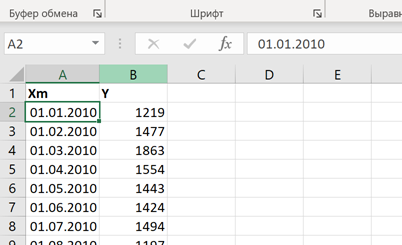

Если книга Excel содержит более одного листа, то можно указать название листа. В этом случае команда будет выглядеть следующим образом:

In [5]:
df=pd.read_excel("forecast_dataset.xlsx", index_col='Xm', sheet_name='Data')
df.head()

,Y
Xm,
2010-01-01,1219.0
2010-02-01,1477.0
2010-03-01,1863.0
2010-04-01,1554.0
2010-05-01,1443.0


Где параметру sheet_name мы присваиваем название страницы ‘Data’.

Чтобы проверить ряд на отсутствие пропусков, выполним его валидацию.

In [6]:
df = validate_series(df)
print(df)

                 Y
Xm                
2010-01-01  1219.0
2010-02-01  1477.0
2010-03-01  1863.0
2010-04-01  1554.0
2010-05-01  1443.0
...            ...
2019-08-01  2192.3
2019-09-01  2333.4
2019-10-01  2606.7
2019-11-01  2527.5
2019-12-01  2491.0

[120 rows x 1 columns]


[<AxesSubplot:>]

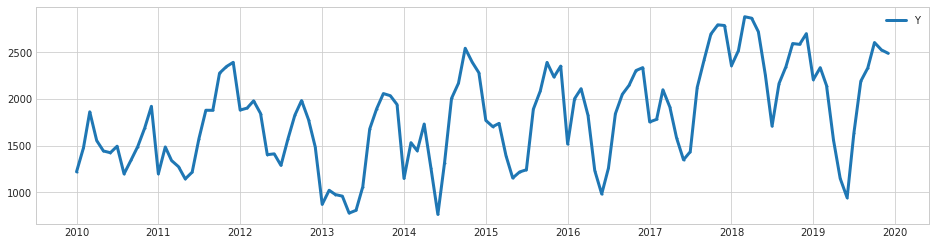

In [7]:
plot(df, ts_linewidth=3)

# Выявление и корректировка анномалий

Следующая команда позволяет изучить основные статистики ряда.

In [8]:
df.describe()

,Y
count,120.000000
mean,1804.510000
std,526.755368
min,762.000000
25%,1400.250000
50%,1825.500000
75%,2215.475000
max,2883.400000


Count – количество значений в датасете.

Mean – среднее значение по ряду.

Std – стандартная ошибка. 

Min – минимальное значение. 

25%, 50%, 75% - значения границ квартилей. 50% - это не что иное, как медиана. В нормально распределенных не смещенных данных, как правило, медиана и среднее значение близки друг к другу. 

Max – максимальное значение.

Используя эти данные, посмотрим на данные и возможные выбросы.

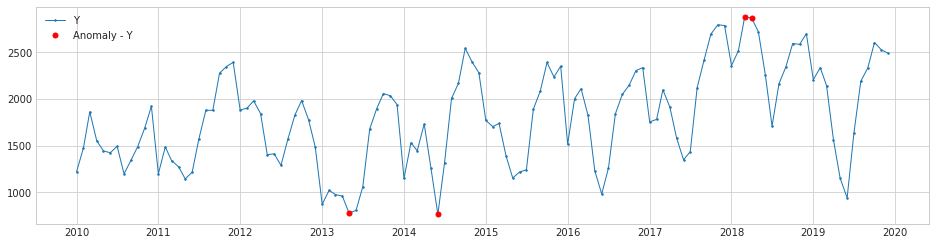

In [9]:
threshold_ad = ThresholdAD(high=2800, low=800)
anomalies = threshold_ad.detect(df)
plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

Корректируя параметры high и low, можно корректировать область детекции аномалий. Сами аномалии подсвечены красными точками. Чтобы увидеть, какие даты попали в аномалии, достаточно выполнить команду:

In [10]:
anomalies[anomalies.Y]

,Y
Xm,
2013-05-01,True
2014-06-01,True
2018-03-01,True
2018-04-01,True


Воспользуемся более сложным детектором аномалий. Следующий детектор основан на оценке отклонения образца ряда от соседей. Метод оценивает, насколько изолирован объект относительно окружения. Точнее, локальность определяется k-ближайшими соседями, расстояние которых используется для оценки локальной плотности. Сравнивая локальную плотность образца с локальными плотностями его соседей, можно идентифицировать образцы, которые имеют существенно меньшую плотность, чем их соседи. Они считаются выбросами.

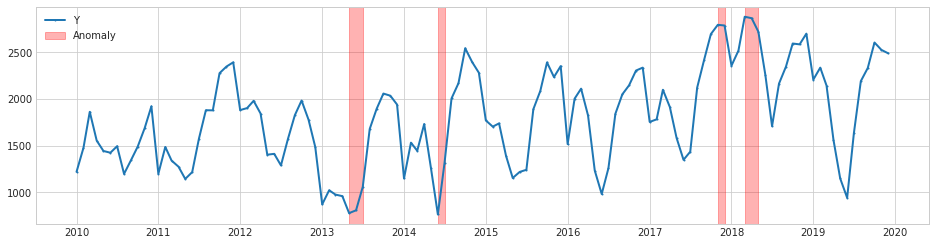

In [11]:
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.05))
anomalies = outlier_detector.fit_detect(df)
plot(df, anomaly=anomalies, ts_linewidth=2, anomaly_color='red', anomaly_alpha=0.3, curve_group='all');

Аномалии подсвечены красным. Изменяя параметр contamination, можно менять чувствительность модели. Чем больше значение, тем более подозрительно она будет относиться к аномалиям. Посмотреть даты, которые модель подозревает на наличие аномалий, можно командой:

In [12]:
anomalies[anomalies]

Xm
2013-05-01    True
2013-06-01    True
2014-06-01    True
2017-11-01    True
2018-03-01    True
2018-04-01    True
dtype: bool

Еще один тест на аномальность – это оценка наличия сезонной компоненты. Построим совмещенные графики по годам. Цифра 12 в параметрах функции означает, сколько периодов длится сезон (если по месяцам – 12, если по кварталам – 4).

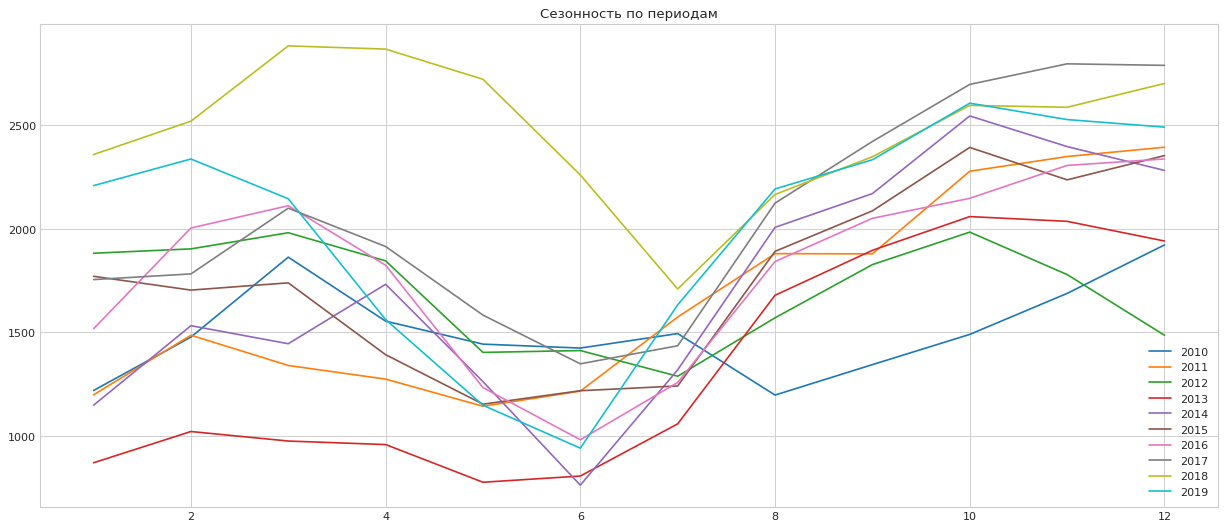

In [13]:
sesonal(df,12)

# Декомпозиция на основе тренда и сезонности

Выделяют три модели представления временного ряда. 
Аддитивная

(Yt)=Tt+St+et

Мультипликативная

(Yt)=Tt×St×et

Смешанная

(Yt)=(Tt+et)×St

где
- (Yt ) ̂- прогнозное значение;
- T – основной сигнал ряда;
- S – коэффициент сезонности;
- e – остатки (ошибка).

Понятие коэффициента сезонности:
- Сезонность - периодические колебания, наблюдаемые на временных рядах.
- Коэффициент сезонности показывает, насколько продажи в данном периоде отклонились от среднего значения.

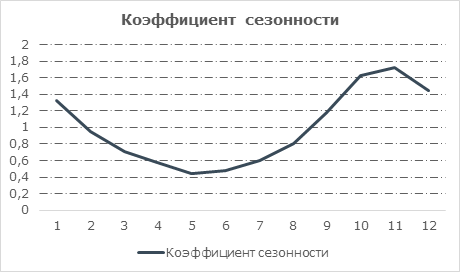

Выполним разложение ряда по мультипликативной модели и изучим результаты.

Обратите внимание на параметр freq. Мы передаем его в модель, чтобы помочь с пониманием количества периодов в одном сезоне. В случае данных с разбивкой по кварталам, freq будет равен 4.

Чтобы получить значения тренда, надо выполнить команду:

Text(0.5, 0.98, 'Мультипликативная модель')

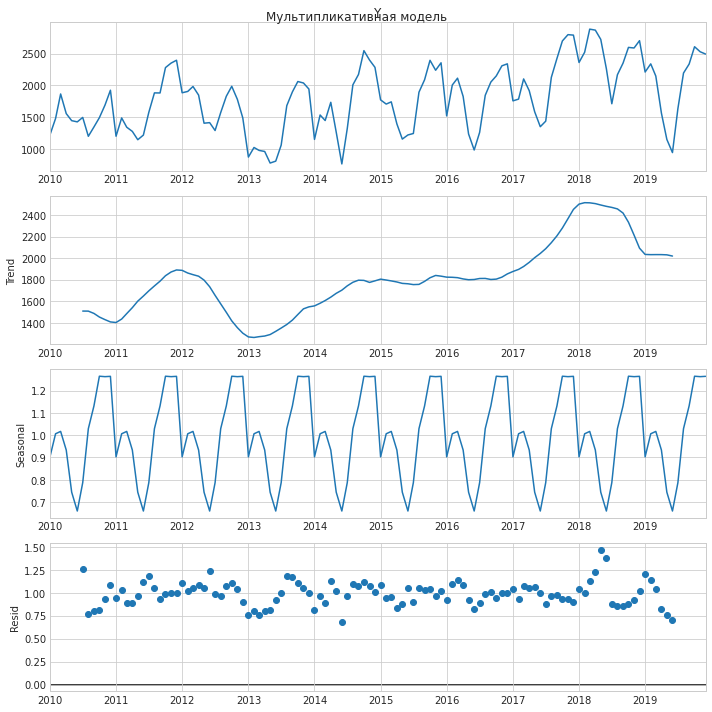

In [14]:
# декомпозиция 
result_M = seasonal_decompose(df.Y, model='multiplicative', freq=12)

# Построение графика
plt.rcParams.update({'figure.figsize': (10,10)})
result_M.plot().suptitle('Мультипликативная модель')

In [15]:
result_M.seasonal['2011']

Xm
2011-01-01    0.902632
2011-02-01    1.006176
2011-03-01    1.016755
2011-04-01    0.933020
2011-05-01    0.743877
2011-06-01    0.659420
2011-07-01    0.786730
2011-08-01    1.028969
2011-09-01    1.131295
2011-10-01    1.264530
2011-11-01    1.262591
2011-12-01    1.264004
Freq: MS, Name: seasonal, dtype: float64

In [16]:
result_M.trend['2011']

Xm
2011-01-01    1402.666667
2011-02-01    1434.458333
2011-03-01    1485.208333
2011-04-01    1540.333333
2011-05-01    1600.708333
2011-06-01    1647.916667
2011-07-01    1696.083333
2011-08-01    1741.958333
2011-09-01    1786.041667
2011-10-01    1836.541667
2011-11-01    1871.166667
2011-12-01    1890.166667
Freq: MS, Name: trend, dtype: float64

Выполним аддитивное разложение ряда, чтобы посмотреть, какой вариант лучше подходит в нашем случае.

Text(0.5, 0.98, 'Адитивная модель')

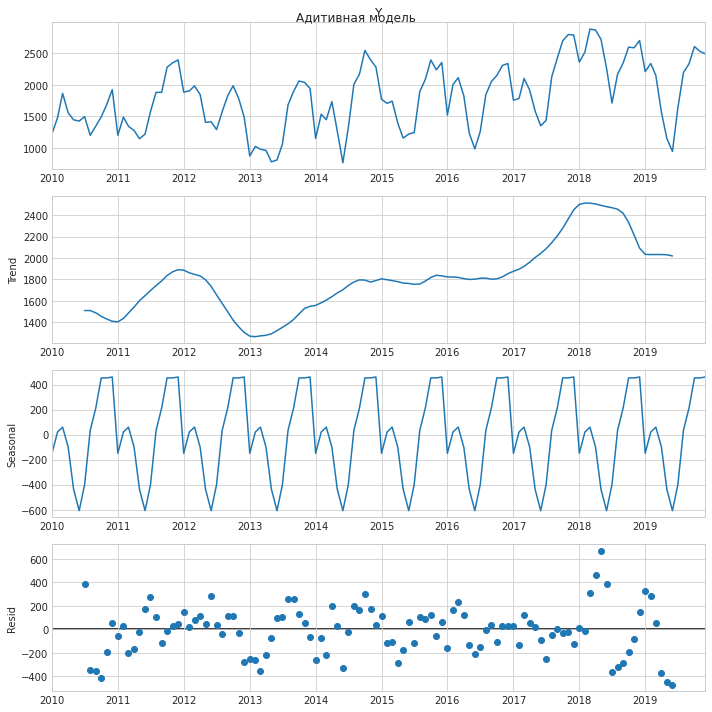

In [17]:
# Decompose 
result_A = seasonal_decompose(df.Y, model='additive', freq=12)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_A.plot().suptitle('Адитивная модель')

In [18]:
result_A.seasonal['2011']

Xm
2011-01-01   -149.517400
2011-02-01     20.922415
2011-03-01     59.600656
2011-04-01   -100.216474
2011-05-01   -436.639622
2011-06-01   -607.482677
2011-07-01   -399.882215
2011-08-01     33.754823
2011-09-01    213.667323
2011-10-01    453.059915
2011-11-01    452.780748
2011-12-01    459.952508
Freq: MS, Name: seasonal, dtype: float64

In [19]:
result_A.trend['2011']

Xm
2011-01-01    1402.666667
2011-02-01    1434.458333
2011-03-01    1485.208333
2011-04-01    1540.333333
2011-05-01    1600.708333
2011-06-01    1647.916667
2011-07-01    1696.083333
2011-08-01    1741.958333
2011-09-01    1786.041667
2011-10-01    1836.541667
2011-11-01    1871.166667
2011-12-01    1890.166667
Freq: MS, Name: trend, dtype: float64

Значения тренда и сезонности мы можем получить аналогичным вышеописанным методом. Единственное, что название модели сменится с result_M на result_A.

# Корректировка ряда

Итог оценки наличия аномалий в году:
- Релевантными для прогноза являются только данные начиная с 2014 года.
- Первое полугодие 2018 года нуждается в корректировке. 

Чтобы скорректировать, достаточно выполнить команду:


In [20]:
df.loc['2018-01-01']=df.loc['2017-01-01']

Аналогично повторить для других месяцев 2018 года начиная с февраля и по июнь.

Построим повторно совмещенный график по месяцам, но уже начиная только с 2014 года.

In [21]:
df.loc['2018-02-01']=df.loc['2017-02-01']
df.loc['2018-03-01']=df.loc['2017-03-01']
df.loc['2018-04-01']=df.loc['2017-04-01']
df.loc['2018-05-01']=df.loc['2017-05-01']
df.loc['2018-06-01']=df.loc['2017-06-01']

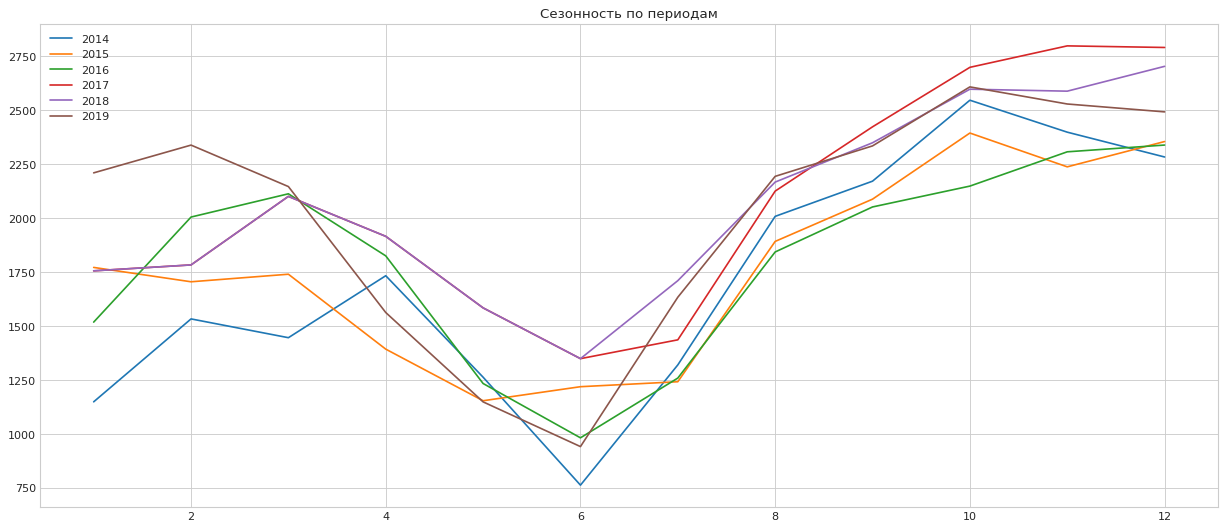

In [22]:
sesonal(df['2014':],12)

В итоге мы получим очищенные данные, пригодные для построения прогноза.

[<AxesSubplot:>]

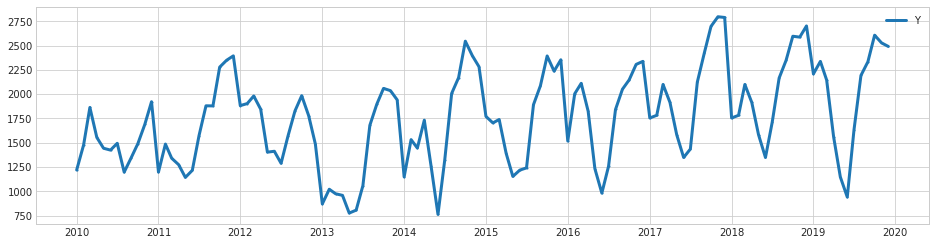

In [23]:
plot(df, ts_linewidth=3)

# Тренировочные и тестовые наборы

Чтобы иметь возможность более качественно оценивать модель, разделим данные на тренировочные и тестовые. Часть данных мы «спрячем» от модели и будем пробовать их предсказать.

In [24]:
train=df['2014':'2018']
train.head()

,Y
Xm,
2014-01-01,1148.0
2014-02-01,1532.0
2014-03-01,1445.0
2014-04-01,1732.0
2014-05-01,1262.0


Тестовые данные возьмем за 7 месяцев 2019 года. 

In [25]:
test=df['2019']
test.head()

,Y
Xm,
2019-01-01,2208.5
2019-02-01,2337.1
2019-03-01,2145.0
2019-04-01,1561.6
2019-05-01,1147.7


# Модель Хольта-Винтерса

Модель Хольта-Винтерса использует идеи модели экспоненциального сглаживания, но является более сложной и может применяться к рядам, содержащим тенденцию и сезонность. 

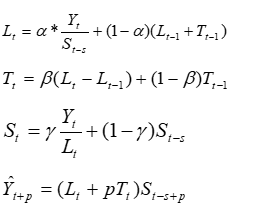

где

Lt – новая сглаженная величина;

α – постоянная сглаживания для данных (0 ≤ α ≥ 1);

Yt – новое наблюдение или реальное значение ряда в период t;

β - постоянная сглаживания для оценки тренда (0 ≤ β ≤1);

Тt - собственно оценка тренда;

(гамма) - постоянная сглаживания для оценки сезонности;

St – оценка сезонности; 

s – длительность периода сезонного колебания;

р – количество периодов вперед, на которое делается прогноз;

Ŷ t+p - прогноз на р периодов вперед.

К счастью, модель реализована в одной из библиотек Python и мы не будем воспроизводить все формулы.

In [26]:
fit1 = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='mul').fit()

In [27]:
fit1.params

{'smoothing_level': 0.005028269275978378,
 'smoothing_trend': 0.005028127185411087,
 'smoothing_seasonal': 0.5330055784247121,
 'damping_trend': nan,
 'initial_level': 1588.9748538235297,
 'initial_trend': 4.378169744938204,
 'initial_seasons': array([0.8702119 , 1.0191829 , 1.02078818, 1.08994902, 0.79417763,
        0.58948059, 0.83004778, 1.26300675, 1.36558278, 1.60157059,
        1.50843407, 1.43606447]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

Первая команда «тренирует» модель fit1. В данном случае реализована классическая модель с аддитивным трендом и мультипликативной сезонной компонентой. Но мы можем построить модель вида в части сочетаний аддитивной и мультипликативной моделей. 

Обратите внимание на параметр seasonal_periods – мы подсказываем модели количество сезонов. Этот параметр необходимо изменить при прогнозировании по кварталам.

Из параметров модели нам интересны:
- 'smoothing_level', 'smoothing_slope', 'smoothing_seasonal' – это постоянные сглаживания для основного ряда данных, тренда и сезонности; 
- 'initial_level' – начальный уровень основного ряда данных; 
- 'initial_slope' – начальный уровень тренда; 
- 'initial_seasons' – начальные значения коэффициентов сезонности.

Мы можем получить расчетные значения для модели и рассчитать метрики точности.

In [28]:
fit1.fittedvalues

Xm
2014-01-01    1386.554760
2014-02-01    1626.968388
2014-03-01    1633.512389
2014-04-01    1747.931420
2014-05-01    1277.015527
2014-06-01     950.384457
2014-07-01    1340.517891
2014-08-01    2045.077074
2014-09-01    2216.908089
2014-10-01    2606.709336
2014-11-01    2461.393236
2014-12-01    2349.243853
2015-01-01    1296.277625
2015-02-01    1626.750817
2015-03-01    1582.754741
2015-04-01    1797.637937
2015-05-01    1309.929547
2015-06-01     876.827482
2015-07-01    1374.980294
2015-08-01    2093.732165
2015-09-01    2265.472724
2015-10-01    2659.214573
2015-11-01    2506.430470
2015-12-01    2387.868573
2016-01-01    1598.887061
2016-02-01    1717.846259
2016-03-01    1716.780540
2016-04-01    1630.540459
2016-05-01    1266.459491
2016-06-01    1093.787154
2016-07-01    1343.367967
2016-08-01    2046.483975
2016-09-01    2236.431265
2016-10-01    2593.900002
2016-11-01    2433.292904
2016-12-01    2441.092286
2017-01-01    1601.916543
2017-02-01    1927.529167
2017-03-0

Рассчитаем прогноз на 12 месяцев вперед.

In [29]:
fit1.forecast(12)

2019-01-01    1802.736461
2019-02-01    1900.231560
2019-03-01    2172.504903
2019-04-01    1974.523144
2019-05-01    1587.965863
2019-06-01    1344.297750
2019-07-01    1627.996995
2019-08-01    2212.393654
2019-09-01    2438.447814
2019-10-01    2699.287673
2019-11-01    2722.834003
2019-12-01    2799.521059
Freq: MS, dtype: float64

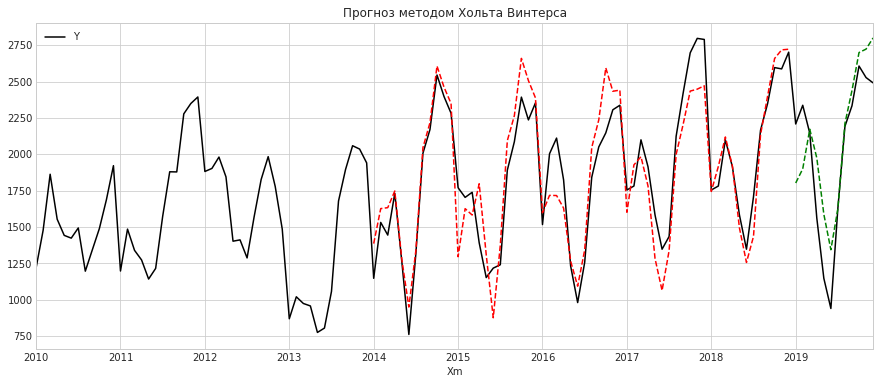

In [30]:
ax = df.plot(figsize=(15,6), color='black', title="Прогноз методом Хольта Винтерса" )
fit1.fittedvalues.plot(ax=ax, style='--', color='red')
fit1.forecast(12).plot(ax=ax, style='--', color='green')
plt.show()

Некоторые комментарии к коду:
- figsize=(15,6) размер картинки по горизонтали и вертикали.
- Color – цвет линии.
- title – название графика.
- style=’—' – заполнение линии, можно изменять. 

#  Оценка качества и точности математических моделей с использованием стандартных метрик (ошибок)

## Среднее абсолютное отклонение

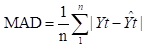

## Среднеквадратическая ошибка 

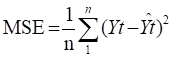

Наиболее важная. Именно на нее обращают внимание в первую очередь, когда сравнивают точность методов между собой. Уменьшение этой ошибки приводит к уменьшению всех остальных ошибок.

## Средняя абсолютная ошибка в процентах

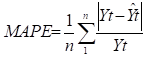

## Средняя процентная ошибка

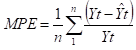

## Тест на стационарность Дики-Фуллера

Тест Дики-Фуллера (DF-тест, Dickey-Fuller test) — это методика, которая используется в прикладной статистике и эконометрике при анализе временных рядов для проверки на стационарность. Является одним из тестов на единичные корни (Unit root test). Был предложен в 1979 году Дэвидом Дики (англ.) и Уэйном Фуллером.
За вклад в исследование коинтегрированных процессов с использованием предложенного теста проверки на стационарность Дики-Фуллера в 2003 году Клайв Грейнджер (Clive Granger) получил Нобелевскую премию по экономике.
Существует три версии теста (тестовых регрессий):
- Без константы и тренда
- С константой, но без тренда:
- С константой и линейным трендом:
 
Для каждой из трех тестовых регрессий существуют свои критические значения DF-статистики, которые берутся из специальной таблицы Дики-Фуллера (МакКиннона). Если значение статистики лежит левее критического значения (критические значения — отрицательные) при данном уровне значимости, то нулевая гипотеза о единичном корне отклоняется и процесс признается стационарным (в смысле данного теста). В противном случае гипотеза не отвергается и процесс может содержать единичные корни, то есть быть нестационарным (интегрированным) временным рядом.

Мы тестируем остатки на стационарность, чтобы понимать, что наша модель смогла извлечь все закономерности из ряда. В противном случае модель использовать нельзя.

## Доверительные интервалы

Упрощенно формулу 95% доверительного интервала можно представить как:

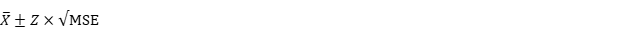

где

Z – двусторонние 95%-ные процентили для t(n)-распределений, в простом случае берем равным 2.

Корень из MSE – это приблизительное значение стандартной ошибки. 

Например, если мы возьмем только одну стандартную ошибку в каждую сторону от прогнозного значения, то получим 68% доверительного интервала. А три стандартные ошибки в каждую сторону дадут уже 95% доверительного интервала.

Найдем метрики результатов моделирования для методом Хольта-Винтерса. Используем уже написанную функцию для расчета всех метрик.

In [31]:
metrics(train, fit1.fittedvalues)

Тест на стационарность:
	T-статистика = -4.747
	P-значение = 0.000
Критические значения :
	1%: -3.5463945337644063 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.911939409384601 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.5936515282964665 - Данные  стационарны с вероятностью 90% процентов
MAD: 156.79
MSE: 38333.3238
MAPE: 0.0902
MPE: -0.004
Стандартная ошибка: 195.789


In [32]:
metrics(test, fit1.forecast(len(test)))

Тест на стационарность:
	T-статистика = -2.247
	P-значение = 0.190
Критические значения :
	1%: -4.9386902332361515 - Данные не стационарны с вероятностью 99% процентов
	5%: -3.477582857142857 - Данные не стационарны с вероятностью 95% процентов
	10%: -2.8438679591836733 - Данные не стационарны с вероятностью 90% процентов
MAD: 237.7592
MSE: 86411.5166
MAPE: 0.1462
MPE: -0.084
Стандартная ошибка: 293.9584


Мы видим, что на тестовых данных точность предсказания падает. На стационарность остатков можно не обращать внимания, так как их немного.

В итоге выберем модель, которая имеет более высокую точность предсказания именно тестовых данных. Чтобы построить прогноз на год вперед возьмем полный набор известных данных (тренировочные + тестовые).

"Натренируем" модели для других вариантов и оценим их как не тренировочном наборе, так и на тестовом. Выберем наиболее точную модель.

Модели сохраним в переменных:
- fit2 (trend='mul', seasonal='mul')
- fit3 (trend='add', seasonal='add')
- fit4 (trend='mul', seasonal='add')

Отобразите лучшуую модель в виде графика.

# SARIMA

Один из наиболее распространенных методов, используемых в прогнозировании временных рядов, известен как модель ARIMA, которая обозначает авторегрессию интегрированного скользящего среднего (ARIMA - от AutoRegressive Integrated Moving Average). ARIMA - это модель, которая может быть адаптирована к данным временного ряда, чтобы лучше понять или предсказать будущие точки в ряду.

Есть три различных целых числа (p, d, q), которые используются для параметризации.

р - авторегрессионная часть модели. Позволяет нам включить влияние прошлых значений в нашу модель. Например, это было бы похоже на заявление о том, что завтра может быть тепло, если последние 3 дня были теплыми.

d является неотъемлемой частью модели. Указывает на количество разностей (то есть количество прошлых временных точек, которые необходимо вычесть из текущего значения) для применения к временному ряду. Например, это может быть похоже на утверждение, что завтра будет такая же температура, если разница в температуре за последние 3 дня была очень мала.

q - скользящая средняя часть модели. Это позволяет нам установить ошибку нашей модели как линейную комбинацию значений ошибок, наблюдаемых в предыдущие моменты времени в прошлом.

При работе с сезонными эффектами мы используем сезонную ARIMA, которая обозначается как SARIMA (p, d, q) (P, D, Q) s.
Здесь (p, d, q) - несезонные параметры, описанные выше, в то время как (P, D, Q) следуют тому же определению, но применяются к сезонной компоненте временного ряда.

Термин s - это периодичность временного ряда (4 для квартальных периодов, 12 для годовых периодов и т.д.).

Сезонный метод ARIMA может показаться пугающим из-за множества параметров настройки, но мы автоматизируем процесс подбора параметров модели.

При поиске соответствия данных временных рядов сезонной модели ARIMA нашей первой целью является поиск значений ARIMA (p, d, q) (P, D, Q), которые оптимизируют интересующую метрику. Мы будем использовать «поиск по сетке», чтобы итеративно исследовать различные комбинации параметров. 

Подбор параметров модели обычно ведут при помощи изучения графика автокорреляции. 

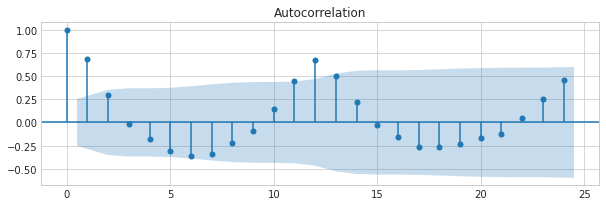

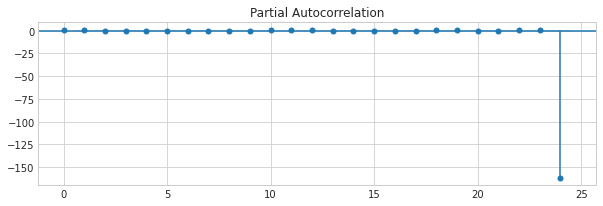

In [33]:
plt.rcParams.update({'figure.figsize': (10,3)})
plot_acf(train.Y, lags=24)
plot_pacf(train.Y, lags=24)
plt.show()

Например, мы видим, что в ряду есть тренд и сезонная компонента. 

Подберем параметры модели.

In [34]:
model = auto_arima(train, seasonal=True, m=12, trace=True, suppress_warnings=True, error_action='ignore', stepwise=True)
model

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=853.317, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=916.842, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=835.186, Time=0.28 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=865.723, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1080.778, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=876.843, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=832.510, Time=0.34 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=859.885, Time=0.14 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.96 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=837.204, Time=0.82 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=843.700, 

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True)

Рассчитаем наиболее точную модель.

In [35]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(1, 0, 0),
                                seasonal_order=(2, 0, 0, 12))

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9163      0.054     16.820      0.000       0.809       1.023
ar.S.L12       0.2815      0.082      3.449      0.001       0.122       0.441
ar.S.L24       0.6452      0.093      6.913      0.000       0.462       0.828
sigma2      3.324e+04   8915.852      3.728      0.000    1.58e+04    5.07e+04


Построим диагностические графики для полученной модели.

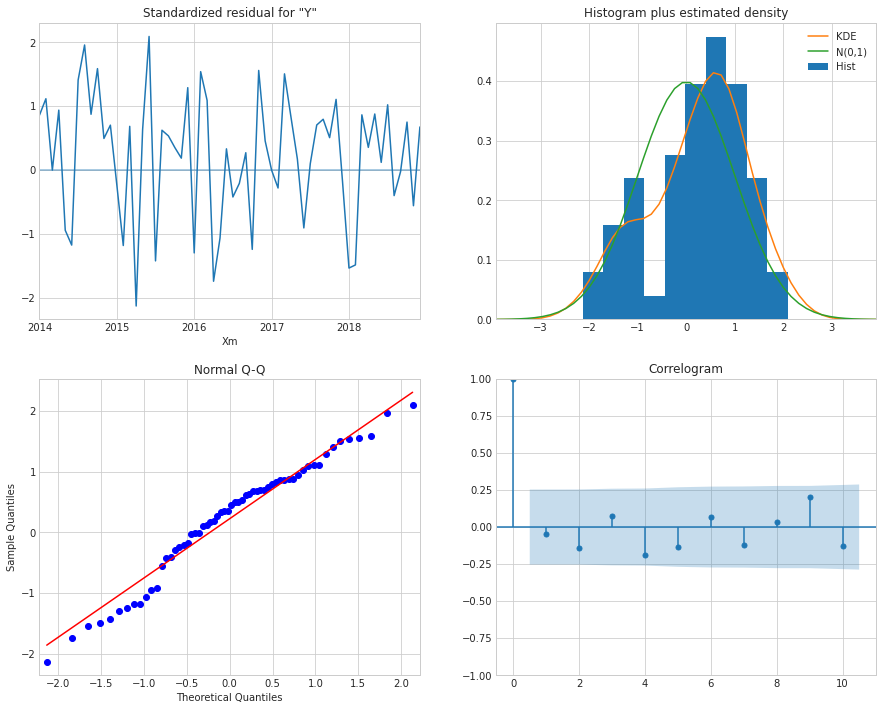

In [36]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Оценим точность нашей модели по стандартным метрикам. Но учтем, что модель не строит прогноз для первого периода. Это можно увидеть, выведя результаты и не задавая начальную дату.

In [37]:
predict=results.get_prediction()
predict.predicted_mean[:10]

Xm
2014-01-01       0.000000
2014-02-01    1098.577870
2014-03-01    1445.395150
2014-04-01    1369.500456
2014-05-01    1624.998835
2014-06-01    1212.204288
2014-07-01     781.371412
2014-08-01    1265.972155
2014-09-01    1842.862248
2014-10-01    1958.754845
Freq: MS, Name: predicted_mean, dtype: float64

In [38]:
predict=results.get_prediction(start='2014-02-01')
metrics(train['2014-02-01':], predict.predicted_mean)

Тест на стационарность:
	T-статистика = -5.455
	P-значение = 0.000
Критические значения :
	1%: -3.5506699942762414 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.913766394626147 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.5946240473991997 - Данные  стационарны с вероятностью 90% процентов
MAD: 201.5654
MSE: 66325.1285
MAPE: 0.121
MPE: 0.02
Стандартная ошибка: 257.5367


Сделаем прогноз на два года вперед и построим график.

In [39]:
predict=results.get_prediction(start='2019', end='2021')

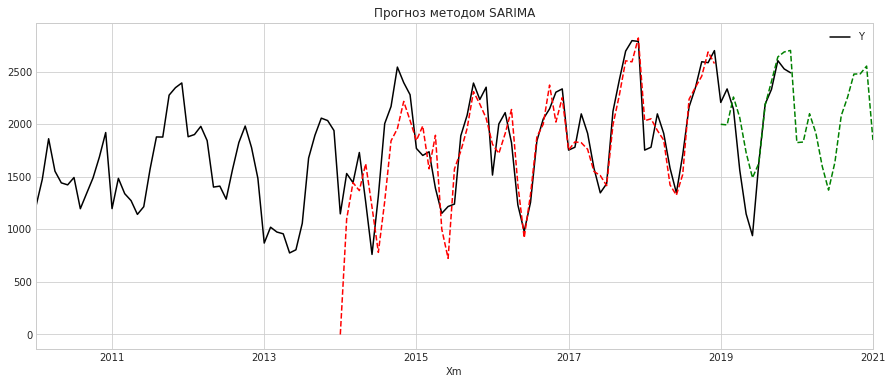

In [40]:
ax = df.plot(figsize=(15,6), color='black', title="Прогноз методом SARIMA" )
results.fittedvalues.plot(ax=ax, style='--', color='red')
predict.predicted_mean.plot(ax=ax, style='--', color='green')
plt.show()

Оценим модель на точность по тестовым данным. 

In [41]:
predict=results.get_prediction(start='2019-01-01', end='2019-07-01')
metrics(test[5:], predict.predicted_mean)

Тест на стационарность:
	T-статистика = -2.510
	P-значение = 0.113
Критические значения :
	1%: -5.354256481481482 - Данные не стационарны с вероятностью 99% процентов
	5%: -3.6462381481481483 - Данные не стационарны с вероятностью 95% процентов
	10%: -2.901197777777778 - Данные не стационарны с вероятностью 90% процентов
MAD: 647.9463
MSE: 559675.2976
MAPE: 0.3697
MPE: -0.0244
Стандартная ошибка: 748.1145


Для прогнозирования будущих периодов необходимо обучить модель на полном наборе данных. Чтобы отобразить результаты прогноза или получить их для редактирования, надо выдать команду:

In [42]:
predict.predicted_mean

2019-01-01    2000.547214
2019-02-01    1994.582415
2019-03-01    2260.081229
2019-04-01    2062.222790
2019-05-01    1730.991488
2019-06-01    1490.929277
2019-07-01    1628.642955
Freq: MS, Name: predicted_mean, dtype: float64

Для экспертного прогнозирования желательно присвоить значения прогноза другой переменной. Редактировать/присваивать новые значения можно, обращаясь по индексу.

In [43]:
res_forecast=predict.predicted_mean

In [44]:
res_forecast['2019-01-01']=2000

In [45]:
res_forecast

2019-01-01    2000.000000
2019-02-01    1994.582415
2019-03-01    2260.081229
2019-04-01    2062.222790
2019-05-01    1730.991488
2019-06-01    1490.929277
2019-07-01    1628.642955
Freq: MS, Name: predicted_mean, dtype: float64

Также данные легко преобразовать в квартальные, если мы будем делать прогноз по кварталам. 

In [46]:
df=df[:'2019-06-01'].resample('Q').sum()
df.tail()

,Y
Xm,
2018-06-30,4845.5
2018-09-30,6222.9
2018-12-31,7884.8
2019-03-31,6690.6
2019-06-30,3649.9


Обратите только внимание, что надо ограничить период таким образом, чтобы у нас формировались полные кварталы. В 2019 году у нас есть только два полных квартала. 

Чтобы сохранить результат достаточно выполнить внутренний метод `to_excel` и указать название файла. Пример ниже. 

In [47]:
res_forecast.to_excel('Result_forecast.xlsx')